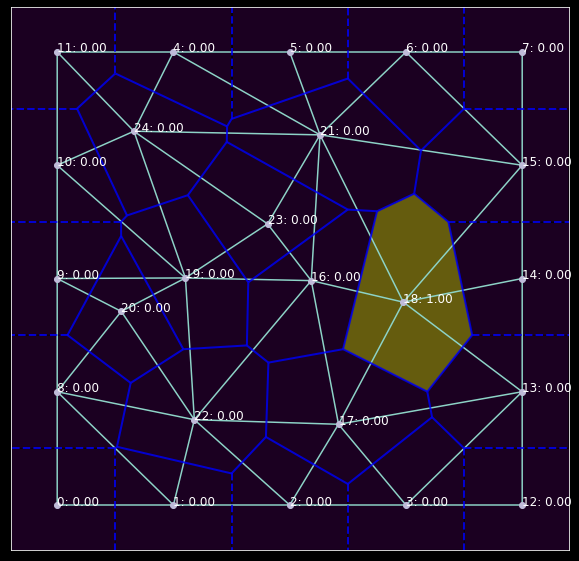

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.]])

In [19]:
import sys, os; sys.path.insert(1, os.path.join(sys.path[0], '..'))
from games.hex.graph_hex_board import GraphHexBoard
import numpy as np
import torch
from matplotlib.cm import ScalarMappable

class VorMoveBoard(GraphHexBoard):
    """
    represents a vortex board from the perspective of a player connecting left to right
    """

    # def __init__(self, edge_index, node_attr, tri, vor_regions):
    #     super().__init__(edge_index, node_attr, tri, vor_regions)

    @property
    def cell_colours(self):
        sm = ScalarMappable(cmap='viridis')
        return sm.to_rgba(self.x)

    def plot(self):
        super().plot()


def get_vor_attr(board, hplays=True):
    VERTICAL_PLAYER = 1
    HORIZONTAL_PLAYER = -1
    F2O_WEIGHT = 0.5
    F2F_WEIGHT = 2

    n_nodes = board.node_attr.size(0)
    v_attr = torch.zeros(n_nodes, 3)

    if hplays:
        them = VERTICAL_PLAYER
        us = HORIZONTAL_PLAYER
        s1, s2 = n_nodes-2, n_nodes-1
    else:
        them = HORIZONTAL_PLAYER
        us = VERTICAL_PLAYER
        s1, s2 = n_nodes-4, n_nodes-3

    board.node_attr[18,0] = us

    # set the stones
    t_mask = board.node_attr[:, 0] == them
    o_mask = board.node_attr[:, 0] == us
    v_attr[o_mask, 2] = 1.
    v_attr[s1] = torch.tensor([1., 0, 0])
    v_attr[s2] = torch.tensor([0, 1., 0])

    # remove edges to other player filled nodes
    their_nodes = t_mask.nonzero().squeeze().numpy()
    ei_np = board.edge_index.numpy()
    m = ~(np.in1d(ei_np[0], their_nodes) | np.in1d(ei_np[1], their_nodes))
    edge_index = board.edge_index[:, m]

    # find filled-to-filled and open-to-filled edges
    our_nodes = o_mask.nonzero().squeeze().numpy()
    ei_np = edge_index.numpy()
    f2f_mask = np.in1d(ei_np[0], our_nodes) & np.in1d(ei_np[1], our_nodes)
    f2o_mask = np.in1d(ei_np[0], our_nodes) ^ np.in1d(ei_np[1], our_nodes)
    # o2o_edges = edge_index[:, ~(f2f_mask|f2o_mask)]
    # f2f_edges = edge_index[:, f2f_mask]
    # f2o_edges = edge_index[:, f2o_mask]
    edge_weights = torch.ones(edge_index.size(1))
    edge_weights[f2o_edges] = F2O_WEIGHT
    edge_weights[f2f_edges] = F2F_WEIGHT

    return v_attr, edge_index, edge_weights


board = VorMoveBoard.new_vortex_board(5)
v_attr, o2o_edges, f2f_edges, f2o_edges = get_vor_attr(board, hplays=True)
board.x = v_attr[:, 2]
board.plot()  

v_attr